## Image classification

> Akshay Bankar (2019201011)

### Convolution Neural Networks

A CNN has


> **Convolutional layers** : The Convolutional layer takes the input image and applies m number of nxn filters to receive a feature map.

> **Activation function layers** : activation function is applied onto the feature maps to increase non-linearity in the network. This is because images themselves are highly non-linear. Convolution is a linear operation with things like element wise matrix multiplication and addition. The real-world data we want our CNN to learn will be non-linear. We can account for that with some non-linear operation performed on feature maps.

> **Pooling layers** : The pooling layer is essentially used for dimensionality reduction, it picks only the best features from the feature map.

> **Fully connected layer** : All the features are flattened and sent as input to the fully connected dense neural network which learns the weights using backpropagation and provides the classification output.

![alt text](https://drive.google.com/uc?id=1kPcMuRaUVPxRCbr_zqZsBFr3bB7mO8I6)


### Classifying images from CIFAR100 dataset using PyTorch

The CIFAR10 dataset consists of 50,000 training images and 10,000 test images of size 32 x 32.

**torch.nn package** : Models are defined in PyTorch by custom classes that extend the Module class. All the components of the models can be found in the torch.nn package.

**torchvision package** : The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. We use this to load CIFAR100 dataset and to perform transformation on the images. 

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")



> Define a mini-network consisting of Convolution-Batchnormalization-Activation.

**nn.Conv2d()** : The function defines aa convolution layer which takes arguments as number of input channels, number of output channels which corresponds to feature detectors and kernel size.


**nn.BatchNorm2d()** : Batch Normalization normalizes all inputs to have zero mean and unit variance.

**Activation layer** : Applies non-linearity to the output of convolution layer depending on the parameter supplied.



In [0]:
class Unit(nn.Module):
    def __init__(self, in_channels, out_channels, activation = 'relu'):
        super(Unit, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=3, out_channels=out_channels, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.activation(output)

        return output



> Using the above defined basic unit, define a neural network model as stack of Convolution-Activation-Pooling layers.



In [0]:
class Net(nn.Module):
    def __init__(self,num_classes=100, activation = 'relu'):
        super(Net,self).__init__()

        self.unit1 = Unit(in_channels=3,out_channels=32, activation=activation)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.unit2 = Unit(in_channels=32, out_channels=64, activation=activation)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.unit3 = Unit(in_channels=64, out_channels=128, activation=activation)
        self.pool3 = nn.MaxPool2d(kernel_size=4)
        
        self.net = nn.Sequential(self.unit1, self.pool1, self.unit2, self.pool2, self.unit3, self.pool3)
        self.fc = nn.Linear(in_features=2*2*128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,2*2*128) ####### 128
        output = self.fc(output)
        return output

**Packages** :

**torch.optim package** : Implements various optimization algorithms like Adam, SGD etc.

**torch.utils.data** : PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset.

**torch.autograd** : provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

In [0]:
from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable

> **Data pre-processing** : This helps the model to classify images properly irrespective of the perspective from which it is displayed.

**Transformations** : RandomHorizontalFlip randomly flips the images horizontally. RandomCrop randomly crops the image.

ToTensor converts the images into a format usable by PyTorch. Normalize with the values given below would make all our pixels range between -1 to +1

In [0]:
#Define transformations for the train set
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Define transformations for the test set
test_transformations = transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

])



> Download and create a loader for training and testing set



In [6]:
batch_size = 32

#Load the training set
train_set = CIFAR100(root="/content/drive/My Drive/computer_vision/assignments/assignment_4/data",train=True,transform=train_transformations,download=True)

#Create a loder for the training set
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)

#Load the test set, note that train is set to False
test_set = CIFAR100(root="/content/drive/My Drive/computer_vision/assignments/assignment_4/data",train=False,transform=test_transformations,download=True)

#Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=4)

cuda_avail = torch.cuda.is_available()

Files already downloaded and verified
Files already downloaded and verified




> Create model, use Adam optimizer, cross entropy loss as loss function.



In [0]:
#Create model, optimizer and loss function
model = Net(num_classes=100)
if cuda_avail:
    model.cuda()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()



> Define function to train the model



In [0]:
def train(num_epochs):
    best_acc = 0.0
    train_loss_lis = []
    train_acc_lis = []
    test_acc_lis = []
    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            #Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            #print(labels.data)
            #Clear all accumulated gradients
            optimizer.zero_grad()
            #Predict classes using images from the test set
            #print(images.shape)
            outputs = model(images)
            #Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs,labels)
            #Backpropagate the loss
            loss.backward()

            #Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            #print(torch.sum(prediction == labels.data))
            train_acc += torch.sum(prediction == labels.data)

        #Call the learning rate adjustment function
        #adjust_learning_rate(epoch)

        #Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / 50000
        train_loss = train_loss / 50000
        train_acc_lis.append(train_acc)
        train_loss_lis.append(train_loss)

        #Evaluate on the test set
        test_acc = test()
        test_acc_lis.append(test_acc)
        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            #save_models(epoch)
            best_acc = test_acc


        # Print the metrics
        if (epoch)%10 == 0 or epoch == num_epochs-1:
            print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))
    return train_loss_lis, train_acc_lis, test_acc_lis



> Define function to test the model



In [0]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
      
        if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

        #Predict classes using images from the test set
        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        #prediction = prediction.cpu().numpy()
        test_acc += torch.sum(prediction == labels.data)
    #Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / 10000

    return test_acc

In [10]:
train_loss_lis, train_acc_lis, test_acc_lis = train(50)

Epoch 0, Train Accuracy: 0.16099999845027924 , TrainLoss: 3.5918188095092773 , Test Accuracy: 0.2703999876976013
Epoch 10, Train Accuracy: 0.507099986076355 , TrainLoss: 1.8428047895431519 , Test Accuracy: 0.4966000020503998
Epoch 20, Train Accuracy: 0.5586999654769897 , TrainLoss: 1.620597004890442 , Test Accuracy: 0.5349999666213989
Epoch 30, Train Accuracy: 0.5800999999046326 , TrainLoss: 1.518107295036316 , Test Accuracy: 0.5564999580383301
Epoch 40, Train Accuracy: 0.5971599817276001 , TrainLoss: 1.461285948753357 , Test Accuracy: 0.555400013923645


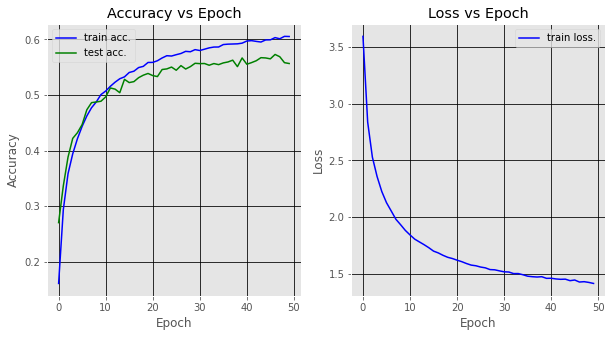

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(list(range(50)),train_acc_lis,'b', label="train acc.")
ax1.plot(list(range(50)),test_acc_lis,'g', label="test acc.")
ax1.legend()
ax1.grid(True, color='k')

ax2.set_title("Loss vs Epoch")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(list(range(50)),train_loss_lis,'b', label="train loss.")
ax2.legend()
ax2.grid(True, color='k')

## Testing with more dense CNN

> Network with **5 Layers of Conv-Batchnorm-Relu** and pooling.

In [0]:
class Net2(nn.Module):
    def __init__(self,num_classes=100, activation = 'relu'):
        super(Net2,self).__init__()

        self.unit1 = Unit(in_channels=3,out_channels=32, activation=activation)
        self.unit2 = Unit(in_channels=32, out_channels=32, activation=activation)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.unit3 = Unit(in_channels=32, out_channels=64, activation=activation)
        self.unit4 = Unit(in_channels=64, out_channels=64, activation=activation)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.unit5 = Unit(in_channels=64, out_channels=128, activation=activation)
        self.avgpool = nn.AvgPool2d(kernel_size=4)
    
        self.net = nn.Sequential(self.unit1, self.unit2, self.pool1, self.unit3, self.unit4, self.pool2, self.unit5, self.avgpool)
        self.fc = nn.Linear(in_features=2*2*128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,2*2*128) ####### 128
        output = self.fc(output)
        return output

In [16]:
#Create model, optimizer and loss function
model = Net2(num_classes=100)
if cuda_avail:
    model.cuda()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

train_loss_lis, train_acc_lis, test_acc_lis = train(50)

Epoch 0, Train Accuracy: 0.16978000104427338 , TrainLoss: 3.489940643310547 , Test Accuracy: 0.26579999923706055
Epoch 10, Train Accuracy: 0.5546999573707581 , TrainLoss: 1.6120166778564453 , Test Accuracy: 0.5489000082015991
Epoch 20, Train Accuracy: 0.6168999671936035 , TrainLoss: 1.3645251989364624 , Test Accuracy: 0.5712000131607056
Epoch 30, Train Accuracy: 0.6409400105476379 , TrainLoss: 1.2568305730819702 , Test Accuracy: 0.597000002861023
Epoch 40, Train Accuracy: 0.6575199961662292 , TrainLoss: 1.193111777305603 , Test Accuracy: 0.6043999791145325
Epoch 49, Train Accuracy: 0.670799970626831 , TrainLoss: 1.1433528661727905 , Test Accuracy: 0.6108999848365784


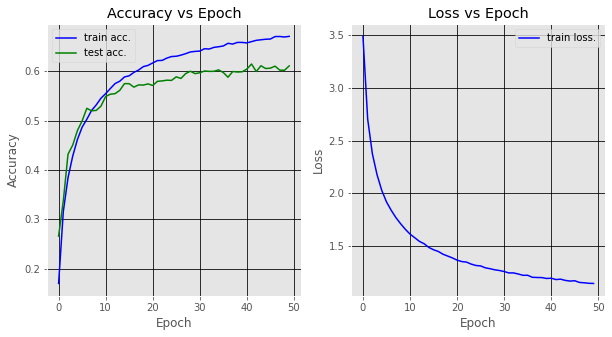

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(list(range(50)),train_acc_lis,'b', label="train acc.")
ax1.plot(list(range(50)),test_acc_lis,'g', label="test acc.")
ax1.legend()
ax1.grid(True, color='k')

ax2.set_title("Loss vs Epoch")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(list(range(50)),train_loss_lis,'b', label="train loss.")
ax2.legend()
ax2.grid(True, color='k')



> Network with 7 layers of Conv-Batchnorm-Relu and 4 pooling layers



In [0]:
class Net3(nn.Module):
    def __init__(self,num_classes=100, activation = 'relu'):
        super(Net3,self).__init__()

        self.unit1 = Unit(in_channels=3,out_channels=32, activation=activation)
        self.unit2 = Unit(in_channels=32, out_channels=32, activation=activation)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.unit3 = Unit(in_channels=32, out_channels=64, activation=activation)
        self.unit4 = Unit(in_channels=64, out_channels=64, activation=activation)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.unit5 = Unit(in_channels=64, out_channels=128, activation=activation)
        self.unit6 = Unit(in_channels=128, out_channels=128, activation=activation)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.unit7 = Unit(in_channels=128, out_channels=128, activation=activation)
        self.avgpool = nn.AvgPool2d(kernel_size=4)
    
        self.net = nn.Sequential(self.unit1, self.unit2, self.pool1, self.unit3, self.unit4, self.pool2, self.unit5, self.unit6, self.pool3, self.unit7, self.avgpool)
        self.fc = nn.Linear(in_features=1*1*128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,1*1*128) ####### 128
        output = self.fc(output)
        return output

In [19]:
#Create model, optimizer and loss function
model = Net3(num_classes=100)
if cuda_avail:
    model.cuda()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

train_loss_lis, train_acc_lis, test_acc_lis = train(50)

Epoch 0, Train Accuracy: 0.11407999694347382 , TrainLoss: 3.7309622764587402 , Test Accuracy: 0.1850999891757965
Epoch 10, Train Accuracy: 0.5756999850273132 , TrainLoss: 1.507434368133545 , Test Accuracy: 0.5511999726295471
Epoch 20, Train Accuracy: 0.6515199542045593 , TrainLoss: 1.2064073085784912 , Test Accuracy: 0.5970999598503113
Epoch 30, Train Accuracy: 0.6840599775314331 , TrainLoss: 1.066609501838684 , Test Accuracy: 0.6146000027656555
Epoch 40, Train Accuracy: 0.7069399952888489 , TrainLoss: 0.9852517247200012 , Test Accuracy: 0.6227999925613403
Epoch 49, Train Accuracy: 0.7207599878311157 , TrainLoss: 0.9321361184120178 , Test Accuracy: 0.6258999705314636


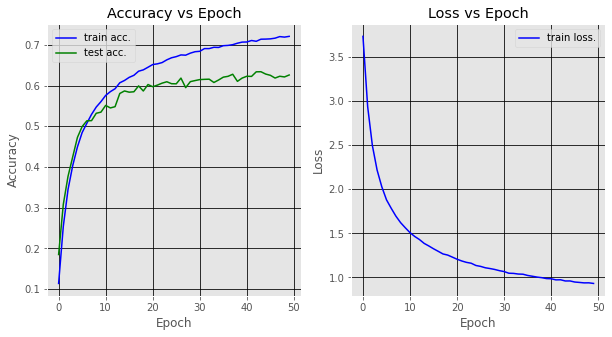

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(list(range(50)),train_acc_lis,'b', label="train acc.")
ax1.plot(list(range(50)),test_acc_lis,'g', label="test acc.")
ax1.legend()
ax1.grid(True, color='k')

ax2.set_title("Loss vs Epoch")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(list(range(50)),train_loss_lis,'b', label="train loss.")
ax2.legend()
ax2.grid(True, color='k')

## Experimentation with different activation functions

*   Activation functions important for a Neural Network to learn and make sense of something really complicated and Non-linear complex functional mappings between the inputs and response variable.They introduce non-linear properties to the Network.
*   Sigmoid Activation function: It is a activation function of form f(x) = 1 / 1 + exp(-x).
$$S(z) = \frac{1} {1 + e^{-z}}$$

*   Hyperbolic Tangent function- Tanh : It’s mathamatical formula is f(x) = 1 — exp(-2x) / 1 + exp(-2x). Now it’s output is zero centered because its range in between -1 to 1 i.e -1 < output < 1 
$$tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}$$

*   ReLu- Rectified Linear units : It is given as R(x) = max(0,x) i.e if x < 0 , R(x) = 0 and if x >= 0 , R(x) = x
$$\begin{split}R(z) = \begin{Bmatrix} z & z > 0 \\
 0 & z <= 0 \end{Bmatrix}\end{split}$$

*   Both Sigmoid and Tanh functions suffer from Vanishing Gradient Problem, Hence ReLu is prefered over these functions.



In [21]:
#Create model, optimizer and loss function
model = Net3(num_classes=100, activation = 'sigmoid')
if cuda_avail:
    model.cuda()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

train_loss_lis, train_acc_lis, test_acc_lis = train(50)

Epoch 0, Train Accuracy: 0.05480000004172325 , TrainLoss: 4.188069820404053 , Test Accuracy: 0.049300000071525574
Epoch 10, Train Accuracy: 0.3682999908924103 , TrainLoss: 2.4012632369995117 , Test Accuracy: 0.2287999987602234
Epoch 20, Train Accuracy: 0.48107999563217163 , TrainLoss: 1.9081615209579468 , Test Accuracy: 0.3450999855995178
Epoch 30, Train Accuracy: 0.5373799800872803 , TrainLoss: 1.6752386093139648 , Test Accuracy: 0.4341999888420105
Epoch 40, Train Accuracy: 0.573199987411499 , TrainLoss: 1.52846360206604 , Test Accuracy: 0.5022000074386597
Epoch 49, Train Accuracy: 0.5946399569511414 , TrainLoss: 1.4426841735839844 , Test Accuracy: 0.48979997634887695


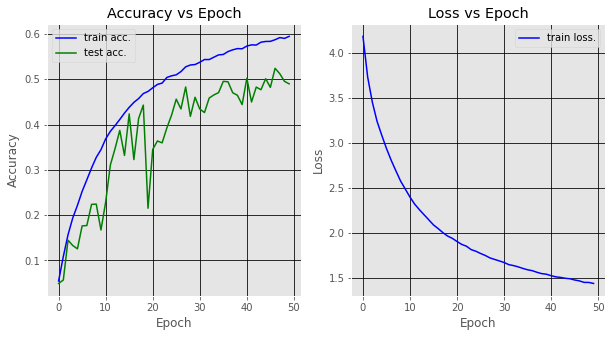

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(list(range(50)),train_acc_lis,'b', label="train acc.")
ax1.plot(list(range(50)),test_acc_lis,'g', label="test acc.")
ax1.legend()
ax1.grid(True, color='k')

ax2.set_title("Loss vs Epoch")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(list(range(50)),train_loss_lis,'b', label="train loss.")
ax2.legend()
ax2.grid(True, color='k')



*   Hyperbolic tan (tanh) activation function



In [23]:
#Create model, optimizer and loss function
model = Net3(num_classes=100, activation = 'tanh')
if cuda_avail:
    model.cuda()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

train_loss_lis, train_acc_lis, test_acc_lis = train(50)

Epoch 0, Train Accuracy: 0.08733999729156494 , TrainLoss: 3.945082902908325 , Test Accuracy: 0.15760000050067902
Epoch 10, Train Accuracy: 0.46469998359680176 , TrainLoss: 1.982926845550537 , Test Accuracy: 0.46949997544288635
Epoch 20, Train Accuracy: 0.5540599822998047 , TrainLoss: 1.6052892208099365 , Test Accuracy: 0.5356999635696411
Epoch 30, Train Accuracy: 0.5993599891662598 , TrainLoss: 1.4169659614562988 , Test Accuracy: 0.5525999665260315
Epoch 40, Train Accuracy: 0.62909996509552 , TrainLoss: 1.3051676750183105 , Test Accuracy: 0.5762999653816223
Epoch 49, Train Accuracy: 0.6463599801063538 , TrainLoss: 1.228898286819458 , Test Accuracy: 0.5767999887466431


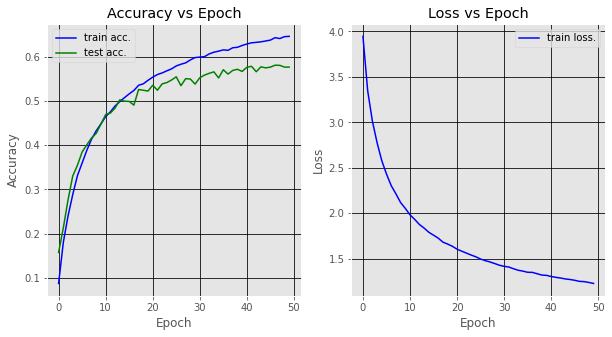

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(list(range(50)),train_acc_lis,'b', label="train acc.")
ax1.plot(list(range(50)),test_acc_lis,'g', label="test acc.")
ax1.legend()
ax1.grid(True, color='k')

ax2.set_title("Loss vs Epoch")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(list(range(50)),train_loss_lis,'b', label="train loss.")
ax2.legend()
ax2.grid(True, color='k')

## Using other loss functions

**Loss Functions for multilabel classification** :

*  **Cross-entropy loss**, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. 

$$-\sum_{c=1}^My_{o,c}\log(p_{o,c})$$



*   **Hinge loss** : It is defined to be $\max(0, 1- y\hat{y})$ where $y \in \{1, -1\}$



In [25]:
#Create model, optimizer and loss function
model = Net3(num_classes=100, activation = 'relu')
if cuda_avail:
    model.cuda()
optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.MultiMarginLoss()

train_loss_lis, train_acc_lis, test_acc_lis = train(50)

Epoch 0, Train Accuracy: 0.10763999819755554 , TrainLoss: 0.4242714047431946 , Test Accuracy: 0.1656000018119812
Epoch 10, Train Accuracy: 0.41523998975753784 , TrainLoss: 0.09780412167310715 , Test Accuracy: 0.4048999845981598
Epoch 20, Train Accuracy: 0.45124000310897827 , TrainLoss: 0.08127337694168091 , Test Accuracy: 0.4399999976158142
Epoch 30, Train Accuracy: 0.4677799940109253 , TrainLoss: 0.0764661654829979 , Test Accuracy: 0.46480000019073486
Epoch 40, Train Accuracy: 0.47387999296188354 , TrainLoss: 0.07260610163211823 , Test Accuracy: 0.4684999883174896
Epoch 49, Train Accuracy: 0.4756599962711334 , TrainLoss: 0.0732487365603447 , Test Accuracy: 0.487199991941452


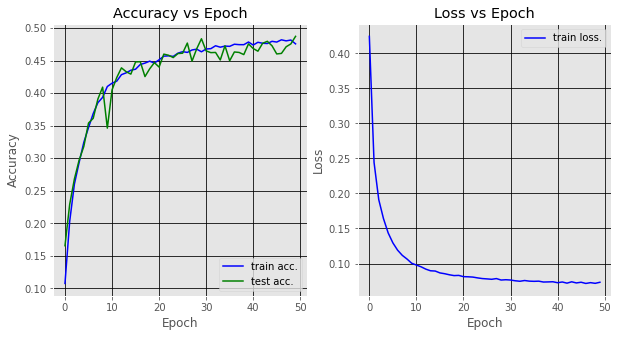

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(list(range(50)),train_acc_lis,'b', label="train acc.")
ax1.plot(list(range(50)),test_acc_lis,'g', label="test acc.")
ax1.legend()
ax1.grid(True, color='k')

ax2.set_title("Loss vs Epoch")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.plot(list(range(50)),train_loss_lis,'b', label="train loss.")
ax2.legend()
ax2.grid(True, color='k')

## Learning rate and weight decay parameter



*   **Learning rate** : It is a parameter that determines how much an updating step influences the current value of the weights.
A cost or error function $E(\mathbf{w})$ that we want to minimize. Gradient descent modifies the weights $\mathbf{w}$ in the direction of steepest descent in $E$ :
$$\begin{equation}
w_i \leftarrow w_i-\eta\frac{\partial E}{\partial w_i},
\end{equation}$$ $\eta$ is learning rate.
*   Weight decay : It is an additional term in the weight update rule that causes the weights to exponentially decay to zero, if no other update is scheduled.

In order to effectively limit the number of free parameters in your model so as to avoid over-fitting, it is possible to regularize the cost function. To do this chang the cost function to $\widetilde{E}(\mathbf{w})=E(\mathbf{w})+\frac{\lambda}{2}\mathbf{w}^2$
This penalizes large weights and effectively limits the freedom in your model. The regularization parameter $\lambda$ determines how we can trade off the original cost $E$ with the large weights penalization.

Applying gradient descent to this new cost function we obtain:
$$\begin{equation}
w_i \leftarrow w_i-\eta\frac{\partial E}{\partial w_i}-\eta\lambda w_i.
\end{equation}$$
The new term $-\eta\lambda w_i$ coming from the regularization causes the weight to decay in proportion to its size.

## Varying learning rate
*   Learning rates of [0.1, 0.01, 0.001]


Learning rate : 0.1
Epoch 0, Train Accuracy: 0.02061999961733818 , TrainLoss: 4.6540350914001465 , Test Accuracy: 0.013100000098347664
Epoch 10, Train Accuracy: 0.020840000361204147 , TrainLoss: 4.605003833770752 , Test Accuracy: 0.009999999776482582
Epoch 20, Train Accuracy: 0.020840000361204147 , TrainLoss: 4.635351657867432 , Test Accuracy: 0.010199999436736107
Epoch 30, Train Accuracy: 0.020659999921917915 , TrainLoss: 4.628040790557861 , Test Accuracy: 0.009999999776482582
Epoch 40, Train Accuracy: 0.022499999031424522 , TrainLoss: 4.598358154296875 , Test Accuracy: 0.009999999776482582
Epoch 49, Train Accuracy: 0.02281999960541725 , TrainLoss: 4.6039628982543945 , Test Accuracy: 0.012199999764561653
Learning rate : 0.01
Epoch 0, Train Accuracy: 0.05469999834895134 , TrainLoss: 4.13230562210083 , Test Accuracy: 0.05920000001788139
Epoch 10, Train Accuracy: 0.2411399930715561 , TrainLoss: 2.9942100048065186 , Test Accuracy: 0.2222999930381775
Epoch 20, Train Accuracy: 0.27617999911

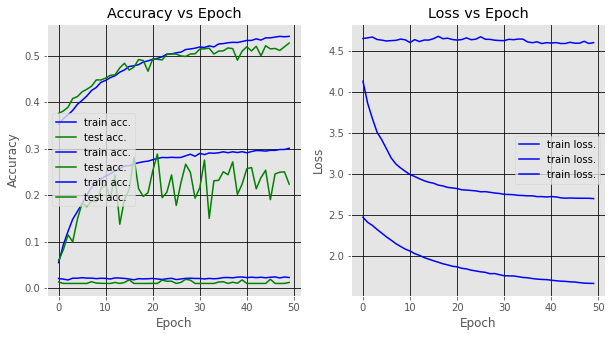

In [27]:
lr = [0.1, 0.01, 0.001]

model = Net3(num_classes=100, activation = 'relu')
if cuda_avail:
    model.cuda()
loss_fn = nn.CrossEntropyLoss()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')

for rate in lr:
    print("Learning rate :", rate)
    optimizer = Adam(model.parameters(), lr=rate,weight_decay=0.0001)
    train_loss_lis, train_acc_lis, test_acc_lis = train(50)
    ax1.plot(list(range(50)),train_acc_lis,'b', label="train acc.")
    ax1.plot(list(range(50)),test_acc_lis,'g', label="test acc.")
    ax1.legend()
    ax1.grid(True, color='k')

    ax2.set_title("Loss vs Epoch")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.plot(list(range(50)),train_loss_lis,'b', label="train loss.")
    ax2.legend()
    ax2.grid(True, color='k')

## Varying weight decay parameters
*   Weight decay parameter [0.1, 0.001, 0.0001]

Weight decay parameter : 0.1
Epoch 0, Train Accuracy: 0.028059998527169228 , TrainLoss: 4.476298809051514 , Test Accuracy: 0.02499999850988388
Epoch 10, Train Accuracy: 0.009800000116229057 , TrainLoss: 4.60538387298584 , Test Accuracy: 0.009999999776482582
Epoch 20, Train Accuracy: 0.009619999676942825 , TrainLoss: 4.605371952056885 , Test Accuracy: 0.009999999776482582
Epoch 29, Train Accuracy: 0.009499999694526196 , TrainLoss: 4.605374813079834 , Test Accuracy: 0.009999999776482582
Weight decay parameter : 0.001
Epoch 0, Train Accuracy: 0.12055999785661697 , TrainLoss: 3.7004358768463135 , Test Accuracy: 0.15569999814033508
Epoch 10, Train Accuracy: 0.507860004901886 , TrainLoss: 1.7857575416564941 , Test Accuracy: 0.5047000050544739
Epoch 20, Train Accuracy: 0.551580011844635 , TrainLoss: 1.6103078126907349 , Test Accuracy: 0.5217999815940857
Epoch 29, Train Accuracy: 0.5670199990272522 , TrainLoss: 1.5528723001480103 , Test Accuracy: 0.5440999865531921
Weight decay parameter : 0.0

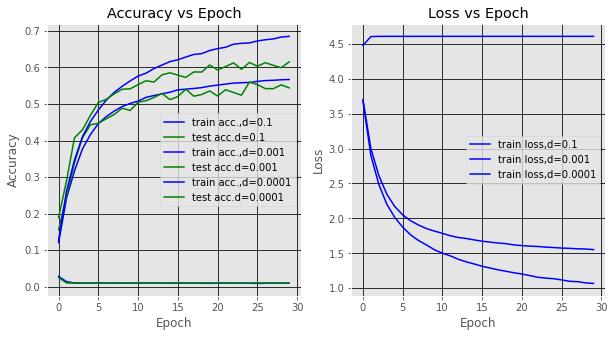

In [30]:
wt_decay = [0.1, 0.001, 0.0001]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title("Accuracy vs Epoch")
ax1.set(xlabel='Epoch', ylabel='Accuracy')

for decay in wt_decay:
    print("Weight decay parameter :", decay)
    model = Net3(num_classes=100, activation = 'relu')
    if cuda_avail:
        model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001,weight_decay=decay)
    train_loss_lis, train_acc_lis, test_acc_lis = train(30)
    ax1.plot(list(range(30)),train_acc_lis,'b', label="train acc.,d="+str(decay))
    ax1.plot(list(range(30)),test_acc_lis,'g', label="test acc.d="+str(decay))
    ax1.legend()
    ax1.grid(True, color='k')

    ax2.set_title("Loss vs Epoch")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.plot(list(range(30)),train_loss_lis,'b', label="train loss,d="+str(decay))
    ax2.legend()
    ax2.grid(True, color='k')